# Imports

In [93]:
#manipulação de dados
import pandas as pd
import numpy  as np

#visualização
import matplotlib.pyplot as plt
import seaborn           as sns
from IPython.core.display import HTML

#metricas
import sklearn.metrics
import scikitplot        as skplt
from scipy import stats

# processamento de dados
import pickle



## Helper functions

In [94]:
# configuração do jupyter notebook e plotagem de imagens
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [95]:
import warnings
warnings.filterwarnings("ignore")

In [96]:
def precision_at_k( data, k=200 ):
    """
    Object that return the precision at k  of recommended items in the top-k set that are relevant
    :param data: dataframe that will be calculated the precision at k position
    :param k: int, default=2000, position that the metric will be calculated default='2000'
    :return: a float value
    """
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k( data, k=200 ):
    """
    Object that return the recall at k  of recommended items in the top-k set that are relevant
    :param data: dataframe that will be calculated the recall at k position
    :param k: int, default=2000, position that the metric will be calculated default='2000'
    :return: a float value
    """
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


def performace(model_name, data, y_val, yhat_class, k=200):
    """

    :param model_name: string, with the name of the algoritm that will be used
    :param data: dataframe sorted by  probabilit given to each iten by the model
    :param y_val: list of the target variable of the dataframe
    :param yhat_class: binary prediction made by the model for each iten
    :param k: int, default=2000 position that the metric will be calculated default='2000'
    :return: a dataframe with the metrics: [precision,recall, balanced accuracy, precision at k, recall at k]
    """
    import sklearn.metrics
    prec = sklearn.metrics.precision_score(y_val, yhat_class,average='macro')
    recal = sklearn.metrics.recall_score(y_val, yhat_class,average='macro')
    balanced_acc = sklearn.metrics.balanced_accuracy_score(y_val, yhat_class)
    recal_k = recall_at_k(data, k)
    prec_k = precision_at_k(data, k)

    return pd.DataFrame({'Model Name': model_name,
                         'Precison': prec,
                         'Recall': recal,
                         'Balanced_acc': balanced_acc,
                         'k': k,
                         'Precison at k': prec_k,
                         'Recall at k': recal_k}, index=[0])



In [97]:
def performace_cross_val(data, target, model, model_name, round_n=4, splits=3, shuffle_n=True, random=42, k=200):
    """
    this cross-validation object uses kfold with stratified folds and return the metrics
    :param data: dataframe
    :param target: string, name of the target variable
    :param model: model that will be used
    :param model_name: string with the model name
    :param round_n: int, default=5number of decimal points of the float values that will be returned
    :param splits: int, default=5, number of folds
    :param shuffle_n:bool, default=True, Whether to shuffle each class’s samples before splitting into batches
    :param random: int, default=42 controls the randomness of each fold
    :param k: int, default=2000 position that the metric will be calculated default='2000'
    :return: a dataframe with the mean and standard deviation of the metrics: [precision,recall, balanced accuracy, precision at k, recall at k]
    """
    import sklearn.model_selection as ms
    import sklearn.metrics
    import numpy as np
    skf = ms.StratifiedKFold(n_splits=splits, shuffle=shuffle_n, random_state=random)
    X = data
    y = X[target]
    X = X.drop(columns=[target, 'id'])
    precision = []
    recall = []
    balan_acc = []
    prec_k = []
    rec_k = []
    for train_index, test_index in skf.split(X, y):
        # train the model
        model.fit(X.iloc[train_index], y.iloc[train_index].values.ravel())

        # predict the classification
        yhat_class = model.predict(X.iloc[test_index])

        # predict the probabilit
        yhat_proba = model.predict_proba(X.iloc[test_index])

        # precision and recall
        prec = sklearn.metrics.precision_score(y.iloc[test_index], yhat_class,average='macro')
        rec = sklearn.metrics.recall_score(y.iloc[test_index], yhat_class,average='macro')
        balan_acc_score = sklearn.metrics.balanced_accuracy_score(y.iloc[test_index], yhat_class)
        precision.append(prec)
        recall.append(rec)
        balan_acc.append(balan_acc_score)

        # sort the test dataframe by the probabiliti score of the model
        aux = X.iloc[test_index]
        aux[target] = y.iloc[test_index]
        aux['score'] = yhat_proba[:, 1].tolist()

        # sorte by score
        aux = aux.sort_values('score', ascending=False)

        # precision and recall at k
        prec_k.append(precision_at_k(aux, k))
        rec_k.append(recall_at_k(aux, k))

    # return a dataset with the metrics
    return pd.DataFrame({'model name': model_name + " CV",
                        'precision_cv': np.round(np.mean(precision), round_n),
                        'prec_std': np.round(np.std(precision), round_n),
                        'recall_cv': np.round(np.mean(recall), round_n),
                        'rec_std': np.round(np.std(recall), round_n),
                        'balanced_acc_cv': np.round(np.mean(balan_acc), round_n),
                        'bal_std': np.round(np.std(balan_acc), round_n),
                        'k': k,
                        'precision_at_k_cv': np.round(np.mean(prec_k), round_n),
                        'perc_k_std': np.round(np.std(prec_k), round_n),
                        'recall_at_k_cv': np.round(np.mean(rec_k), round_n),
                        'rec_k_std': np.round(np.std(rec_k))}, index=[0])




# Load data 

In [98]:
path_local = 'C:/Users/Lavin/Documents/desafios/ifood/'

In [99]:
val   = pd.read_csv(path_local + 'src/data/df_val.csv')

## Load model

In [100]:
brf_model = pickle.load(open(path_local + 'src/models/brf_final_model.pkl','rb'))

In [101]:
x_val = val.copy()
y_val = x_val['response']
x_val = x_val.drop(columns=['id','response'])

In [102]:
#model prediction proba - poder de generalização
yhat_brf_proba = brf_model.predict_proba( x_val )

#model prediction - poder de generalização
yhat_brf_class = brf_model.predict( x_val )

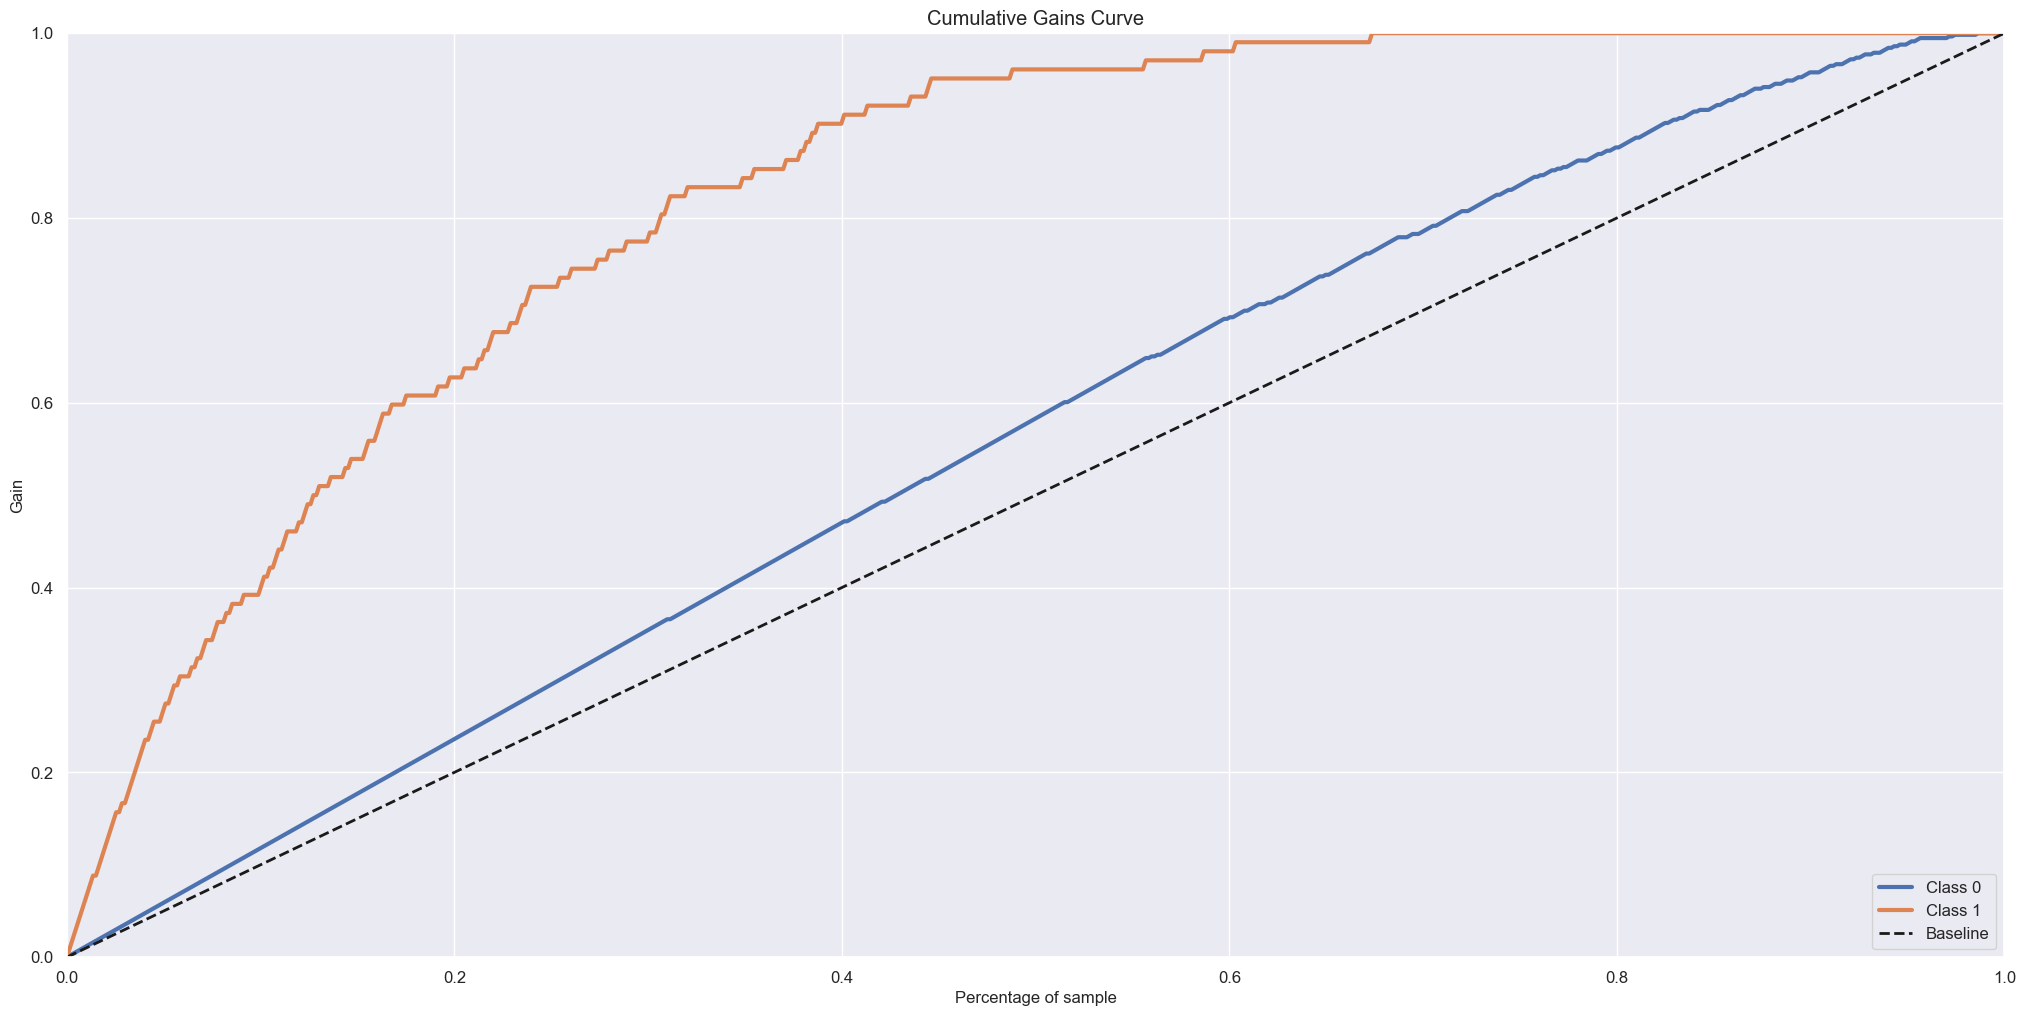

In [103]:
skplt.metrics.plot_cumulative_gain(y_val,yhat_brf_proba);

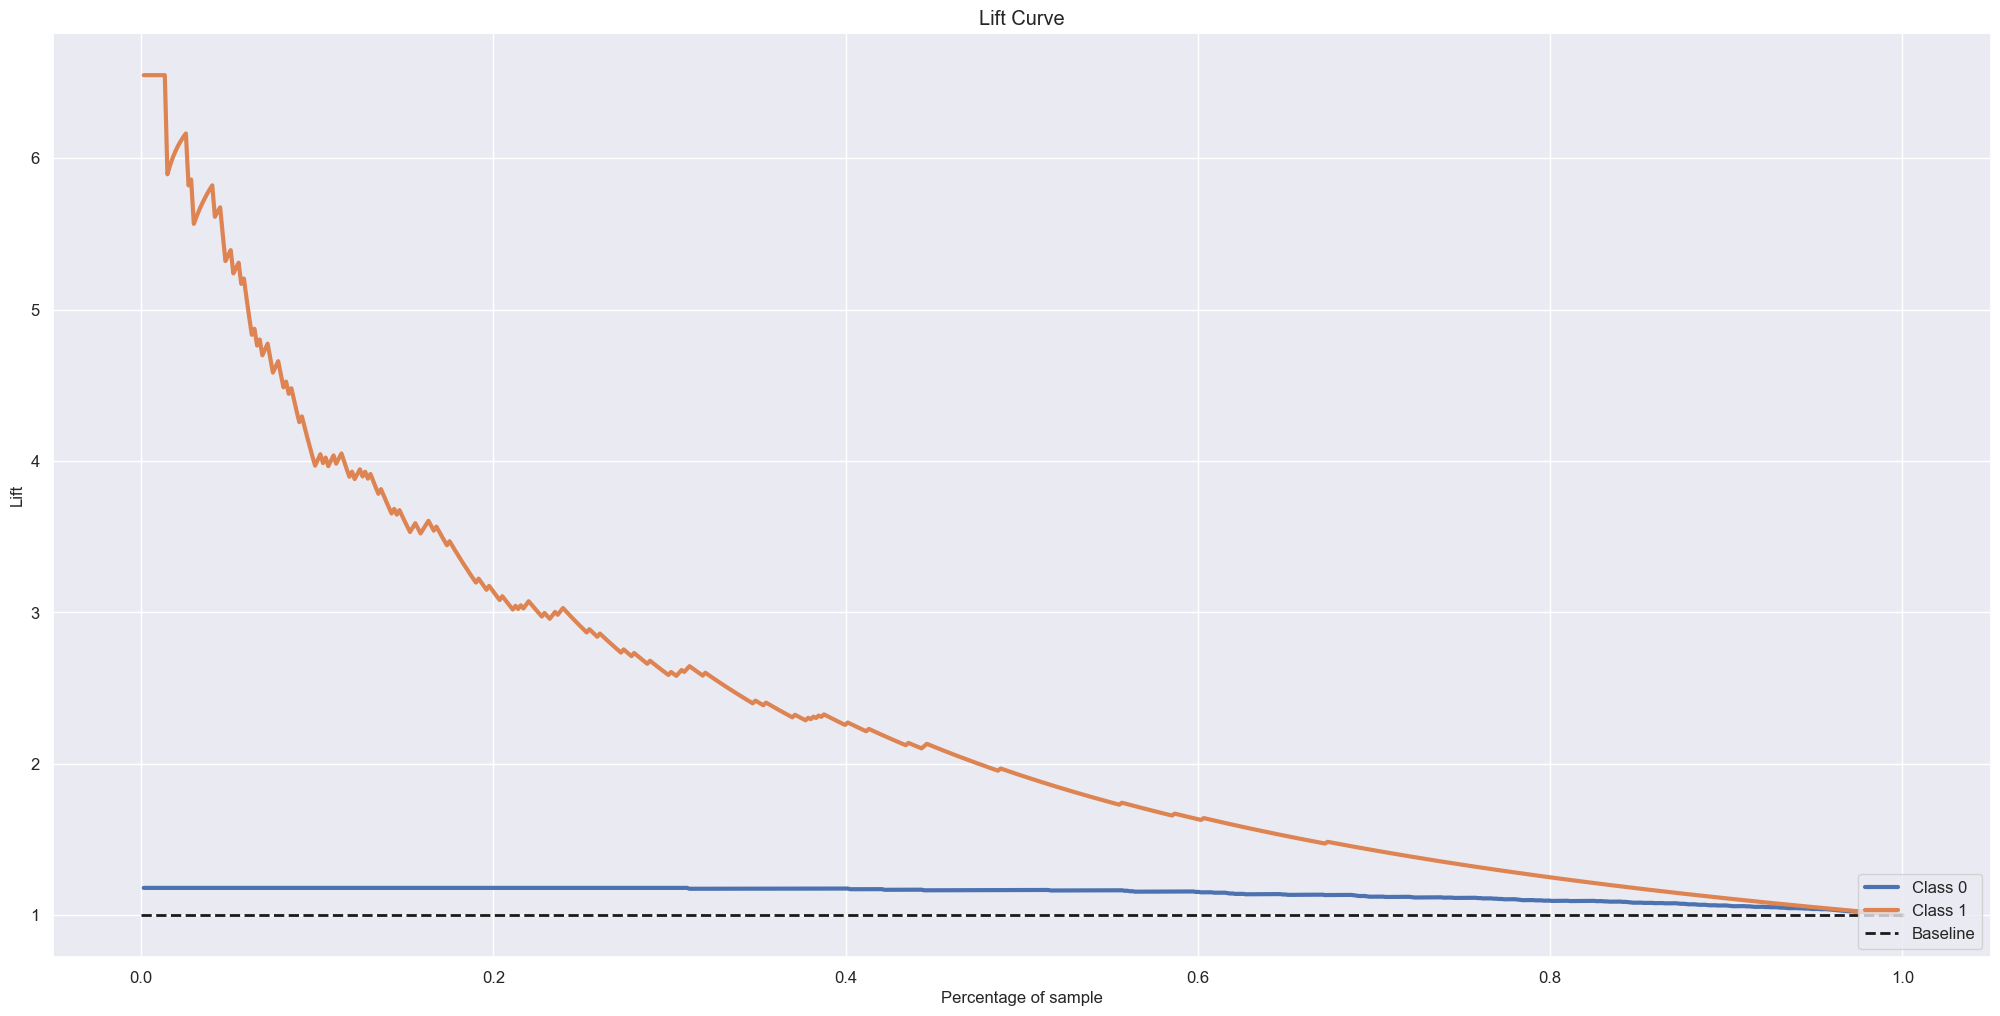

In [104]:
skplt.metrics.plot_lift_curve(y_val,yhat_brf_proba);

## 11.1  Model performace 

In [105]:
clients = 200

In [106]:
brf_df = val.copy()

In [107]:
lista = ['mnt_sweet_products',
 'num_web_visits_month',
 'recency',
 'mnt_fish_products',
 'num_store_purchases',
 'num_deals_purchases',
 'mnt_fruits',
 'mnt_gold_prods',
 'mnt_wines',
 'income',
 'age',
 'total_spent',
 'num_web_purchases',
 'mnt_meat_products',
 'income_per_member',
 'days_since_signup',
 'num_catalog_purchases']

for item in lista:
    scaler = pickle.load(open(path_local + 'src/features/' + item + '_scaler.pkl','rb'))
    brf_df[item] = scaler.inverse_transform(brf_df[[item]])

mari = {0.39: 'Married', 0.25: 'Together', 0.22: 'Single', 0.11: 'Divorced', 0.03: 'Widow', 0.0: 'Alone'}

#frequêncy encoding
brf_df['marital_status'] = brf_df['marital_status'].map(mari)

In [108]:
brf_df['score_brf'] = yhat_brf_proba[:,1].tolist()
#sort by score

brf_df = brf_df.sort_values('score_brf',ascending=False)

In [109]:
brf_df

,id,marital_status,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,...,accepted_cmp5,accepted_cmp1,age,n_family_members,days_since_signup,income_per_member,total_spent,total_accepted,response,score_brf
561,3584,Single,49667.0,35.0,1181.0,26.0,120.0,17.0,13.0,39.0,...,0,0,65.0,1,678.0,49667.000000,1396.0,1,1,0.926667
65,830,Single,74004.0,5.0,784.0,48.0,560.0,42.0,176.0,48.0,...,1,1,33.0,1,125.0,74004.000000,1658.0,2,1,0.920000
156,3725,Single,84865.0,1.0,1248.0,16.0,349.0,43.0,16.0,16.0,...,1,1,59.0,1,416.0,84865.000000,1688.0,4,1,0.920000
385,3005,Single,83528.0,7.0,530.0,117.0,678.0,134.0,44.0,147.0,...,0,1,28.0,1,59.0,83528.000000,1650.0,2,1,0.910000
476,3619,Divorced,87305.0,19.0,345.0,25.0,501.0,63.0,138.0,80.0,...,1,0,60.0,1,644.0,87305.000000,1152.0,1,1,0.910000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,1834,Single,35544.0,77.0,30.0,5.0,23.0,4.0,1.0,4.0,...,0,0,42.0,2,113.0,17772.000000,67.0,0,0,0.020000
291,10839,Together,36283.0,42.0,6.0,5.0,5.0,8.0,0.0,5.0,...,0,0,44.0,4,76.0,9070.750000,29.0,0,0,0.020000
386,5223,Together,45903.0,80.0,33.0,8.0,10.0,2.0,10.0,3.0,...,0,0,54.0,3,67.0,15301.000000,66.0,0,0,0.020000
489,7325,Together,38197.0,86.0,23.0,0.0,11.0,2.0,1.0,3.0,...,0,0,34.0,3,365.0,12732.333333,40.0,0,0,0.010000


# Performace de négocio

## Qual porcentagem de clientes interresados o time de marketing consigurá contatar oferecendo a ofertar para os primeiros 20% dos clienetes da lista ordenada?

In [110]:
clients = 133
perct= round(recall_at_k(brf_df,clients)*100,2)

In [111]:
print('Com ' + str(clients) + ' ligações o time de vendas atingirá '+str(perct) + "% dos clientes interresados em toda base disponível, considerando que ao total se tem " + str(len(brf_df)) + 
      " de possíveis clientes, "+str(clients)+" represanta apenas " + str(round((clients/len(brf_df))*100,2)) + "% do total, ou seja, ligando para menos de um quinto da base de dados é possivel atingir mais da metade dos possivelmente interresados ")

Com 133 ligações o time de vendas atingirá 62.75% dos clientes interresados em toda base disponível, considerando que ao total se tem 668 de possíveis clientes, 133 represanta apenas 19.91% do total, ou seja, ligando para menos de um quinto da base de dados é possivel atingir mais da metade dos possivelmente interresados 


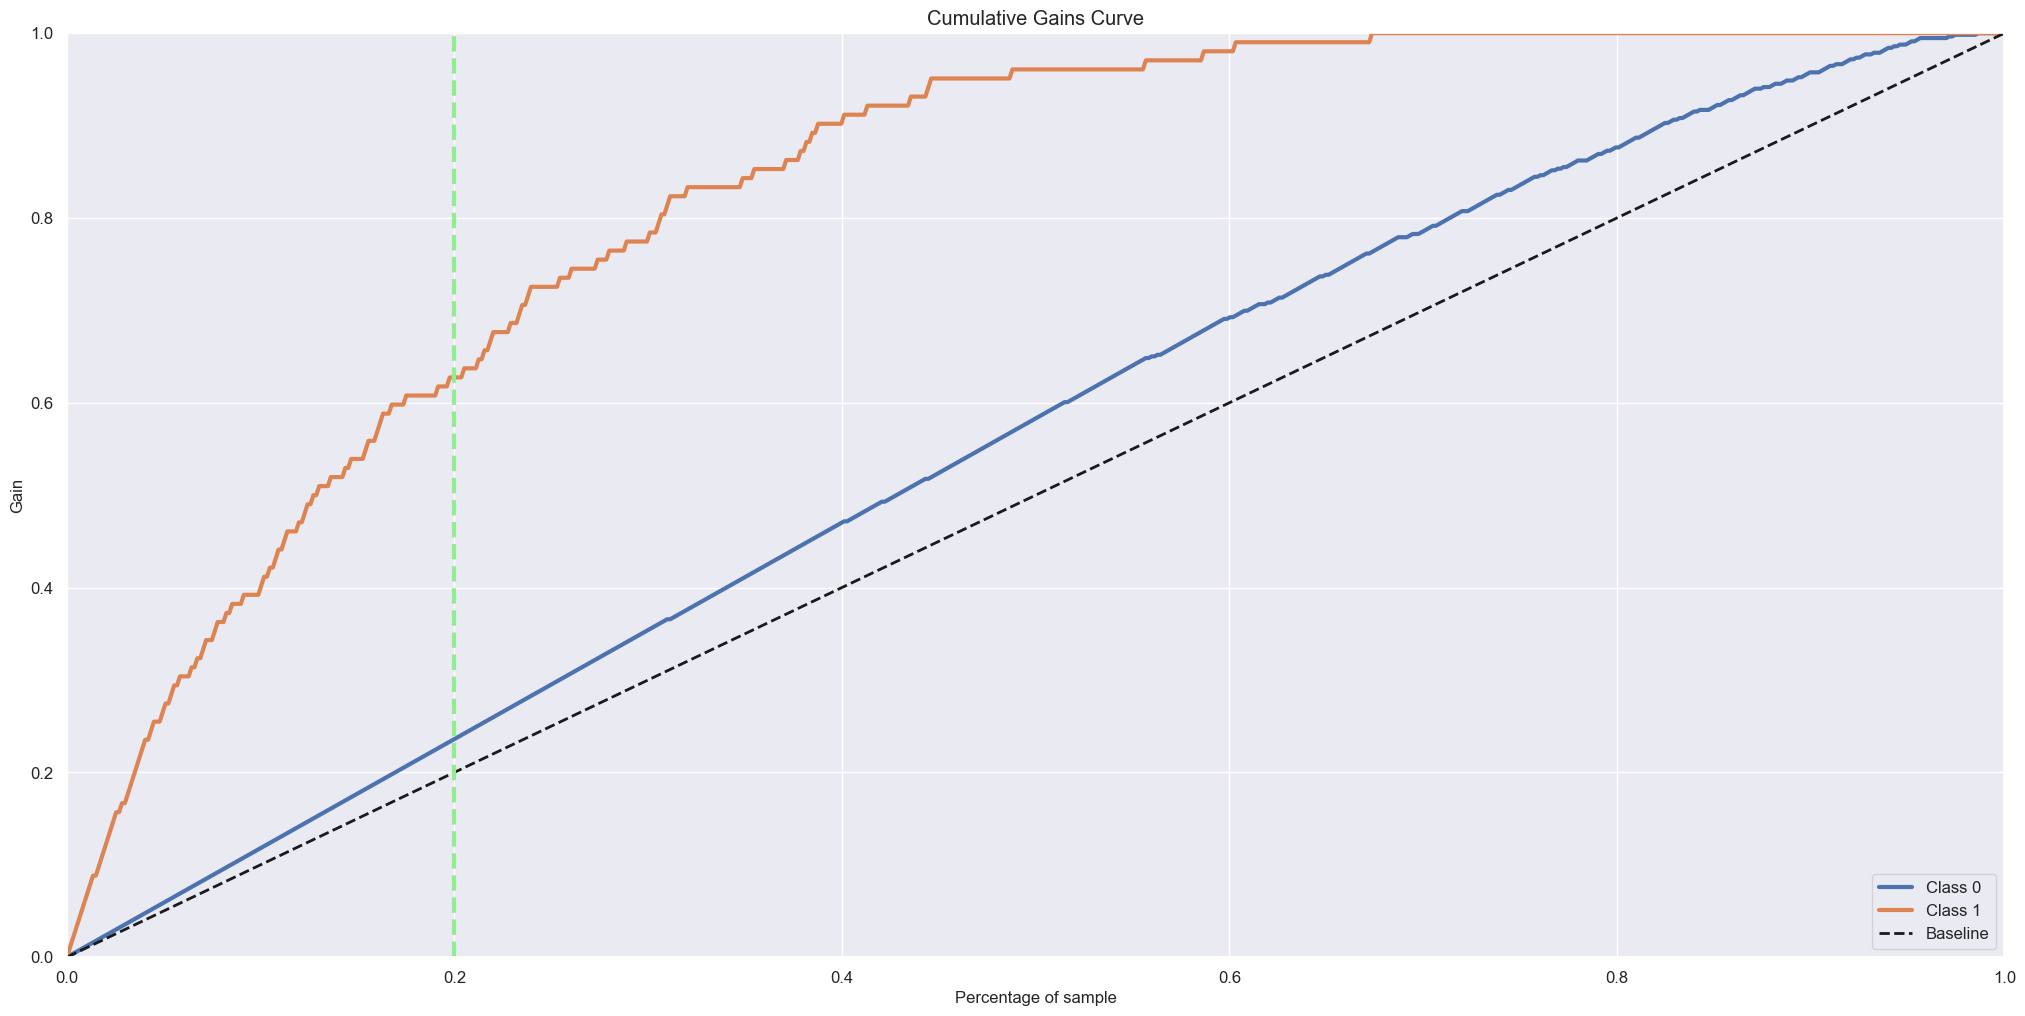

In [117]:
skplt.metrics.plot_cumulative_gain(y_val,yhat_brf_proba);
plt.axvline(0.2, 0, 1, color='lightgreen', ls='--', lw=3)

In [112]:
random_model = int((clients/len(brf_df)) * y_val.value_counts()[1])
balanced_model = int(recall_at_k(brf_df,clients) * y_val.value_counts()[1])

In [113]:
print("Utilizando o modelo aleátorio, que poderia ser só uma seleção aleátoria dos clientes ou uma simples ordenação por algum atributo, ligando para " +str(clients) + " clientes atingiriamos apenas " + str(random_model) + " dos " + str(y_val.value_counts()[1]) +" clientes interresados, já como o nosso modelo atingimos " +
str(balanced_model) + ", assim, captando " + str(round(balanced_model/random_model,2),) + " vezes mais potênciais clientes")

Utilizando o modelo aleátorio, que poderia ser só uma seleção aleátoria dos clientes ou uma simples ordenação por algum atributo, ligando para 133 clientes atingiriamos apenas 20 dos 102 clientes interresados, já como o nosso modelo atingimos 64, assim, captando 3.2 vezes mais potênciais clientes


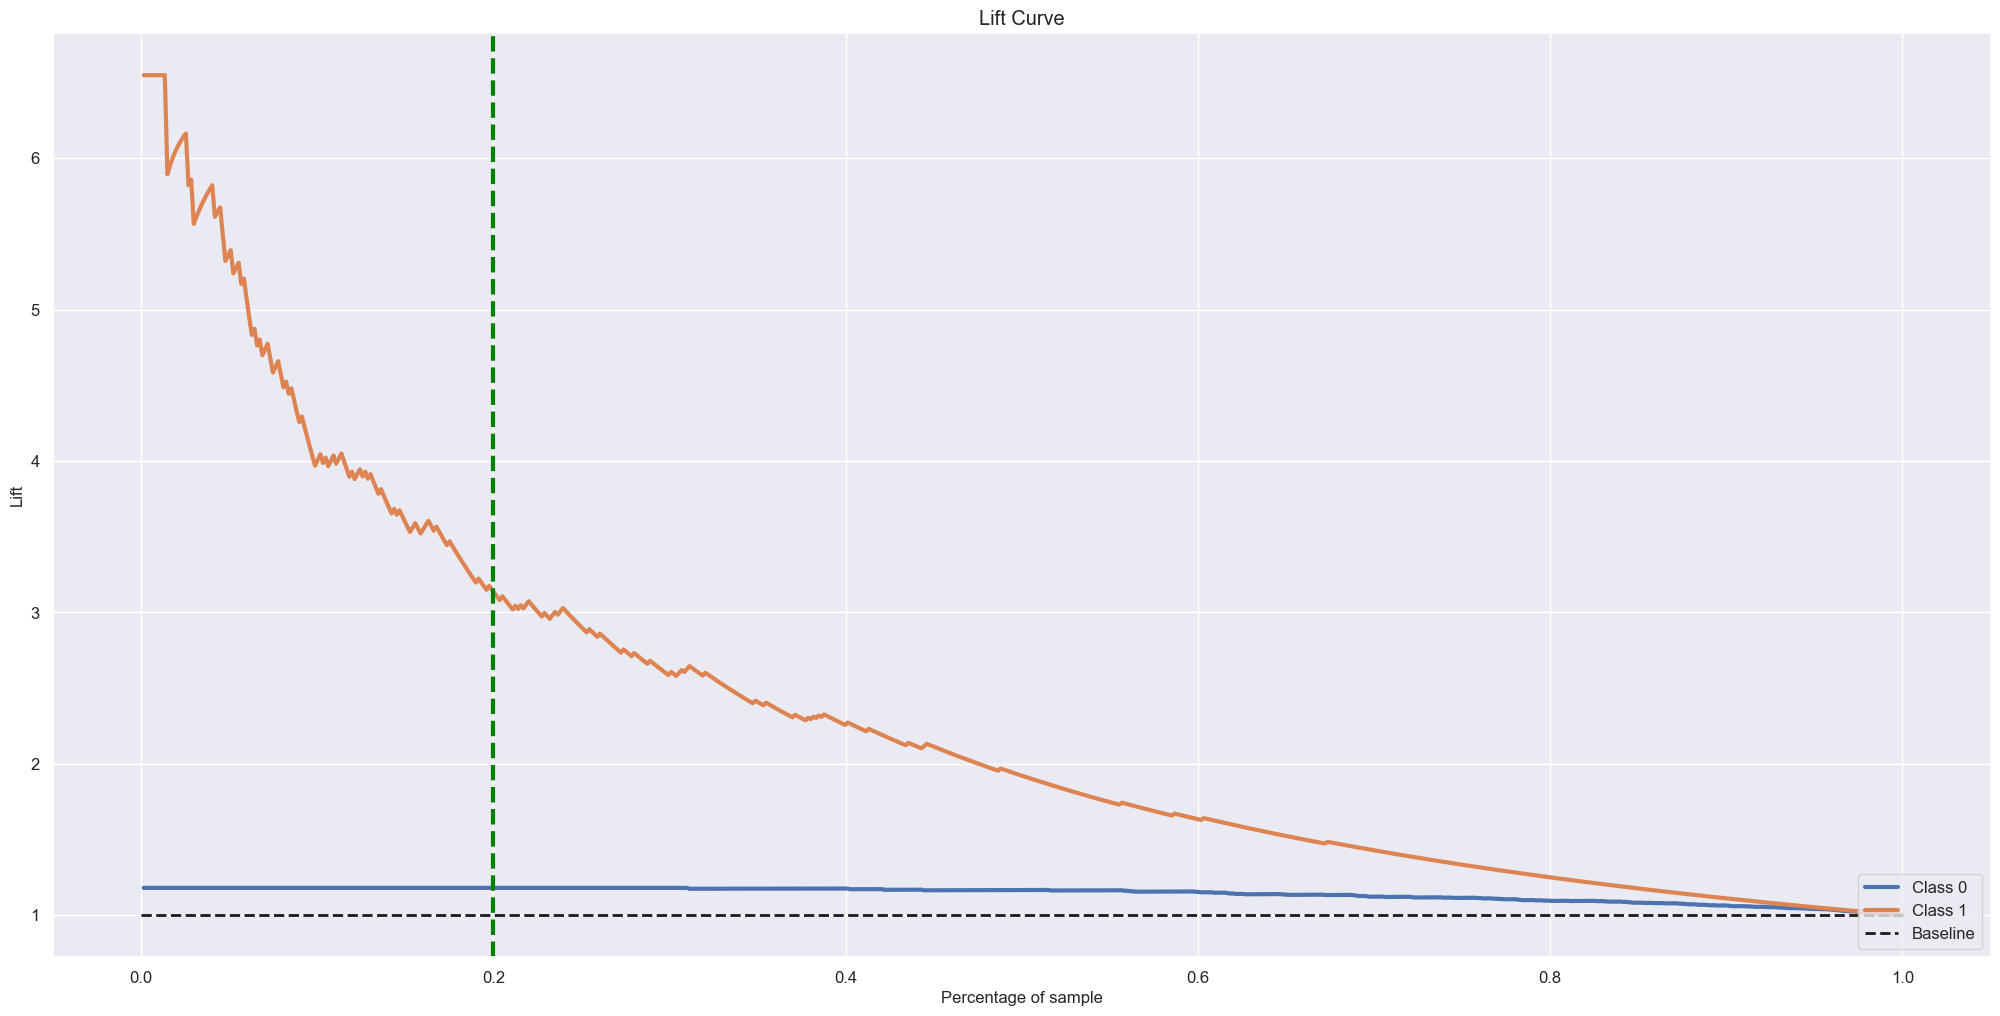

In [114]:
skplt.metrics.plot_lift_curve(y_val,yhat_brf_proba);
plt.axvline(0.2, 0, 1, color='green', ls='--', lw=3)

## Se a capacidade do time de marketing dobrar? qual a porcentagem de potênciais clientes que será atingida?

In [118]:
clients = 266
perct= round(recall_at_k(brf_df,clients)*100,2)

In [120]:
print('Com ' + str(clients) + ' ligações o time de vendas atingirá '+str(perct) + "% dos clientes interresados em toda base disponível, considerando que ao total se tem " + str(len(brf_df)) + 
      " de possíveis clientes, "+str(clients)+" represanta apenas " + str(round((clients/len(brf_df))*100,2)) + "% do total, ou seja, ligando para menos da metade base de dados é possivel atingir a grande maioria dos possivelmente interresados ")

Com 266 ligações o time de vendas atingirá 90.2% dos clientes interresados em toda base disponível, considerando que ao total se tem 668 de possíveis clientes, 266 represanta apenas 39.82% do total, ou seja, ligando para menos da metade base de dados é possivel atingir a grande maioria dos possivelmente interresados 


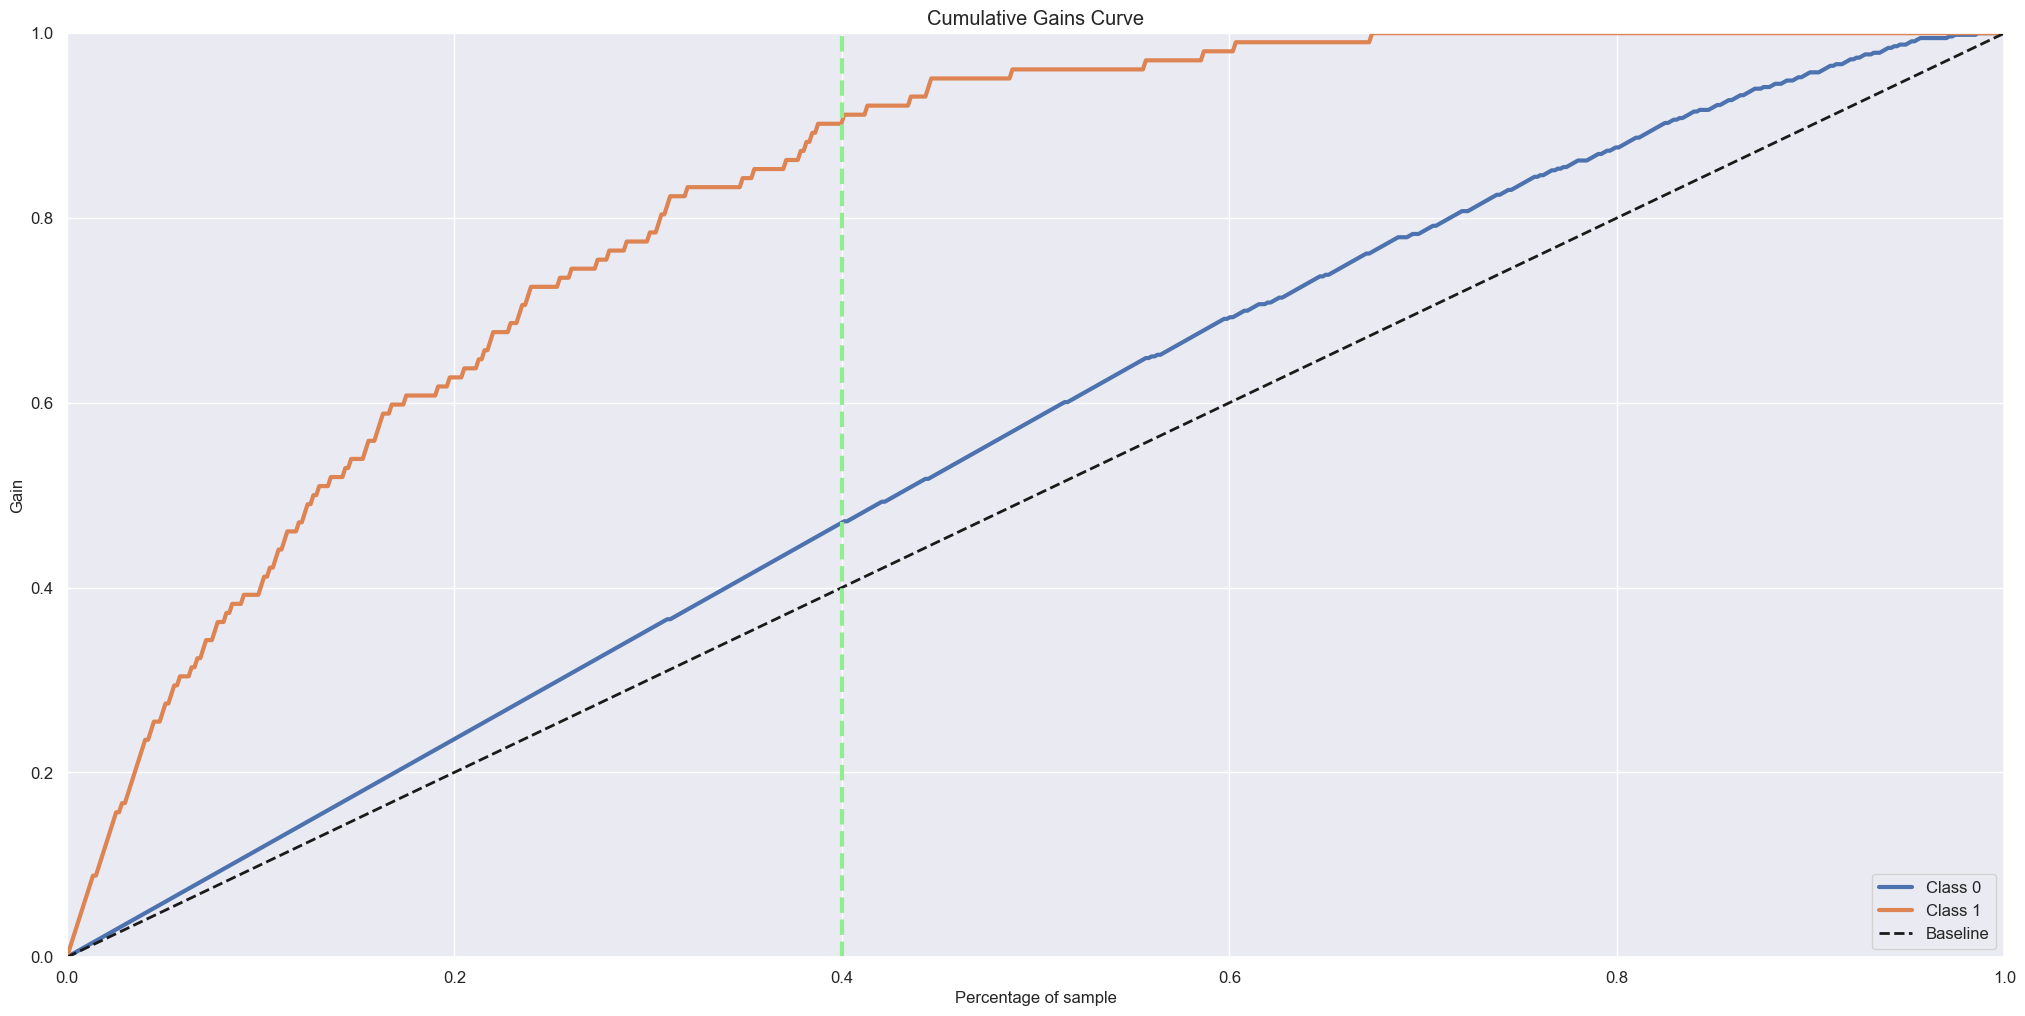

In [121]:
skplt.metrics.plot_cumulative_gain(y_val,yhat_brf_proba);
plt.axvline(0.4, 0, 1, color='lightgreen', ls='--', lw=3)

In [122]:
random_model = int((clients/len(brf_df)) * y_val.value_counts()[1])
balanced_model = int(recall_at_k(brf_df,clients) * y_val.value_counts()[1])

In [123]:
print("Utilizando o modelo aleátorio, que poderia ser só uma seleção aleátoria dos clientes ou uma simples ordenação por algum atributo, ligando para " +str(clients) + " clientes atingiriamos apenas " + str(random_model) + " dos " + str(y_val.value_counts()[1]) +" clientes interresados, já como o nosso modelo atingimos " +
str(balanced_model) + ", assim, captando " + str(round(balanced_model/random_model,2),) + " vezes mais potênciais clientes")

Utilizando o modelo aleátorio, que poderia ser só uma seleção aleátoria dos clientes ou uma simples ordenação por algum atributo, ligando para 266 clientes atingiriamos apenas 40 dos 102 clientes interresados, já como o nosso modelo atingimos 92, assim, captando 2.3 vezes mais potênciais clientes


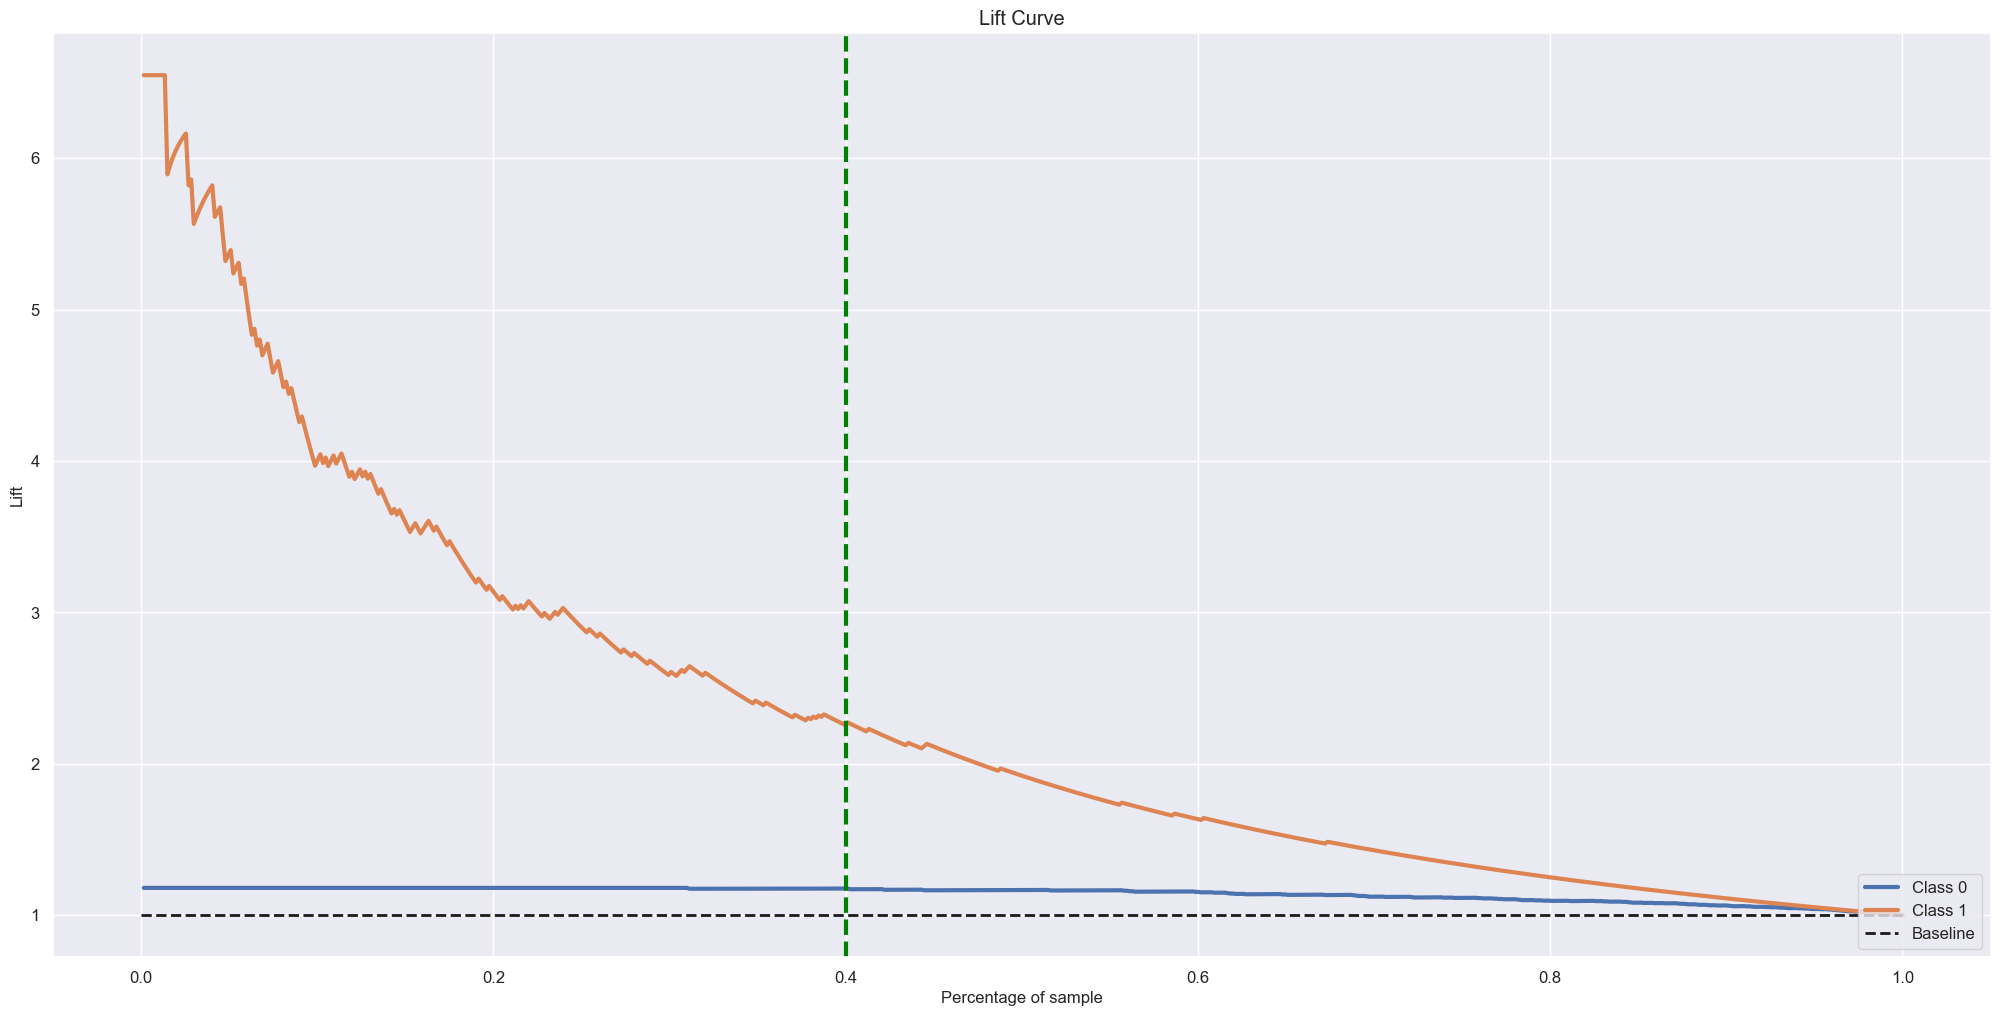

In [125]:
skplt.metrics.plot_lift_curve(y_val,yhat_brf_proba);
plt.axvline(0.4, 0, 1, color='green', ls='--', lw=3)